# TensorFlow Core Learning Algorithms - Linear Regression

We will not do Linear regression using Keras.

In [536]:



from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [537]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [538]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


2.3.1


## Training Data
We now prepare data for taring purpose. The data needs to be modified with all text values mapped to numeric values etc.

In [539]:
raw_dataset = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
raw_dataset.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [540]:
train_data = raw_dataset.copy()
train_data.tail()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
622,0,male,28.0,0,0,10.50,Second,unknown,Southampton,y
623,0,male,25.0,0,0,7.05,Third,unknown,Southampton,y
624,1,female,19.0,0,0,30.00,First,B,Southampton,y
625,0,female,28.0,1,2,23.45,Third,unknown,Southampton,n
626,0,male,32.0,0,0,7.75,Third,unknown,Queenstown,y


In [541]:
# Check the data types. Anything that is not numeric will need to be converted.
train_data.dtypes

survived                int64
sex                    object
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                  object
deck                   object
embark_town            object
alone                  object
dtype: object

### Clean Training Data

Clean up invalid data.

In [542]:
# Check if any data is na
train_data.isna().sum()

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [543]:
train_data = train_data.dropna()
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
survived,627.0,0.387560,0.487582,0.00,0.0000,0.0000,1.0000,1.0000
age,627.0,29.631308,12.511818,0.75,23.0000,28.0000,35.0000,80.0000
n_siblings_spouses,627.0,0.545455,1.151090,0.00,0.0000,0.0000,1.0000,8.0000
parch,627.0,0.379585,0.792999,0.00,0.0000,0.0000,0.0000,5.0000
fare,627.0,34.385399,54.597730,0.00,7.8958,15.0458,31.3875,512.3292


### Convert to Numeric

Lets convert the non numeric data into a numeric data since the model expects everything to be numeric.

In [544]:
CATEGORICAL_COLUMNS = ['sex', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare', 'n_siblings_spouses', 'parch',]

In [545]:
# Find all unique values and map them to numeric values.

temp_data = train_data.copy() # make a deep copy. Not needed but just in case.
cat2num = {}
for cc in CATEGORICAL_COLUMNS:
    kv = {} # e.g {"male":1}
    ii = 1
    for unq in temp_data.sort_values(cc)[cc].unique(): # First Sort, then get unique values
        kv[unq] = ii
        ii += 1
    cat2num[cc] = kv

print(cat2num)

{'sex': {'female': 1, 'male': 2}, 'class': {'First': 1, 'Second': 2, 'Third': 3}, 'deck': {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'unknown': 8}, 'embark_town': {'Cherbourg': 1, 'Queenstown': 2, 'Southampton': 3, 'unknown': 4}, 'alone': {'n': 1, 'y': 2}}


In [546]:
print(temp_data['class'].value_counts())
print(temp_data['deck'].value_counts())
print(temp_data['embark_town'].value_counts())
print(temp_data['alone'].value_counts())


Third     341
First     159
Second    127
Name: class, dtype: int64
unknown    481
C           43
B           37
E           23
D           22
A           11
F            6
G            4
Name: deck, dtype: int64
Southampton    450
Cherbourg      123
Queenstown      53
unknown          1
Name: embark_town, dtype: int64
y    372
n    255
Name: alone, dtype: int64


In [547]:
print("Before: ", train_data.head())

# Use replace to do the conversion to numeric.
train_data.replace(cat2num, inplace=True)

print("After: ", train_data.head())



Before:     survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
After:     survived  sex   age  n_siblings_spouses  parch     fare  class  deck  \
0         0    2  22.0                   1      0   7.2500      3     8   
1         1    1  38.0                   1      0  71.2833      1     3   
2         1    1  26.0                   0      0   7.9250      3     8   
3         1    1  35.0                   1      0  53.1000

In [548]:
# Lets check the data types after conversion
train_data.dtypes

survived                int64
sex                     int64
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                   int64
deck                    int64
embark_town             int64
alone                   int64
dtype: object

In [549]:
train_data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
survived,627.0,0.387560,0.487582,0.00,0.0000,0.0000,1.0000,1.0000
sex,627.0,1.653907,0.476103,1.00,1.0000,2.0000,2.0000,2.0000
age,627.0,29.631308,12.511818,0.75,23.0000,28.0000,35.0000,80.0000
n_siblings_spouses,627.0,0.545455,1.151090,0.00,0.0000,0.0000,1.0000,8.0000
parch,627.0,0.379585,0.792999,0.00,0.0000,0.0000,0.0000,5.0000
fare,627.0,34.385399,54.597730,0.00,7.8958,15.0458,31.3875,512.3292
class,627.0,2.290271,0.845181,1.00,1.0000,3.0000,3.0000,3.0000
deck,627.0,6.904306,2.107441,1.00,8.0000,8.0000,8.0000,8.0000
embark_town,627.0,2.524721,0.803712,1.00,2.0000,3.0000,3.0000,4.0000
alone,627.0,1.593301,0.491610,1.00,1.0000,2.0000,2.0000,2.0000


### Inspect the data


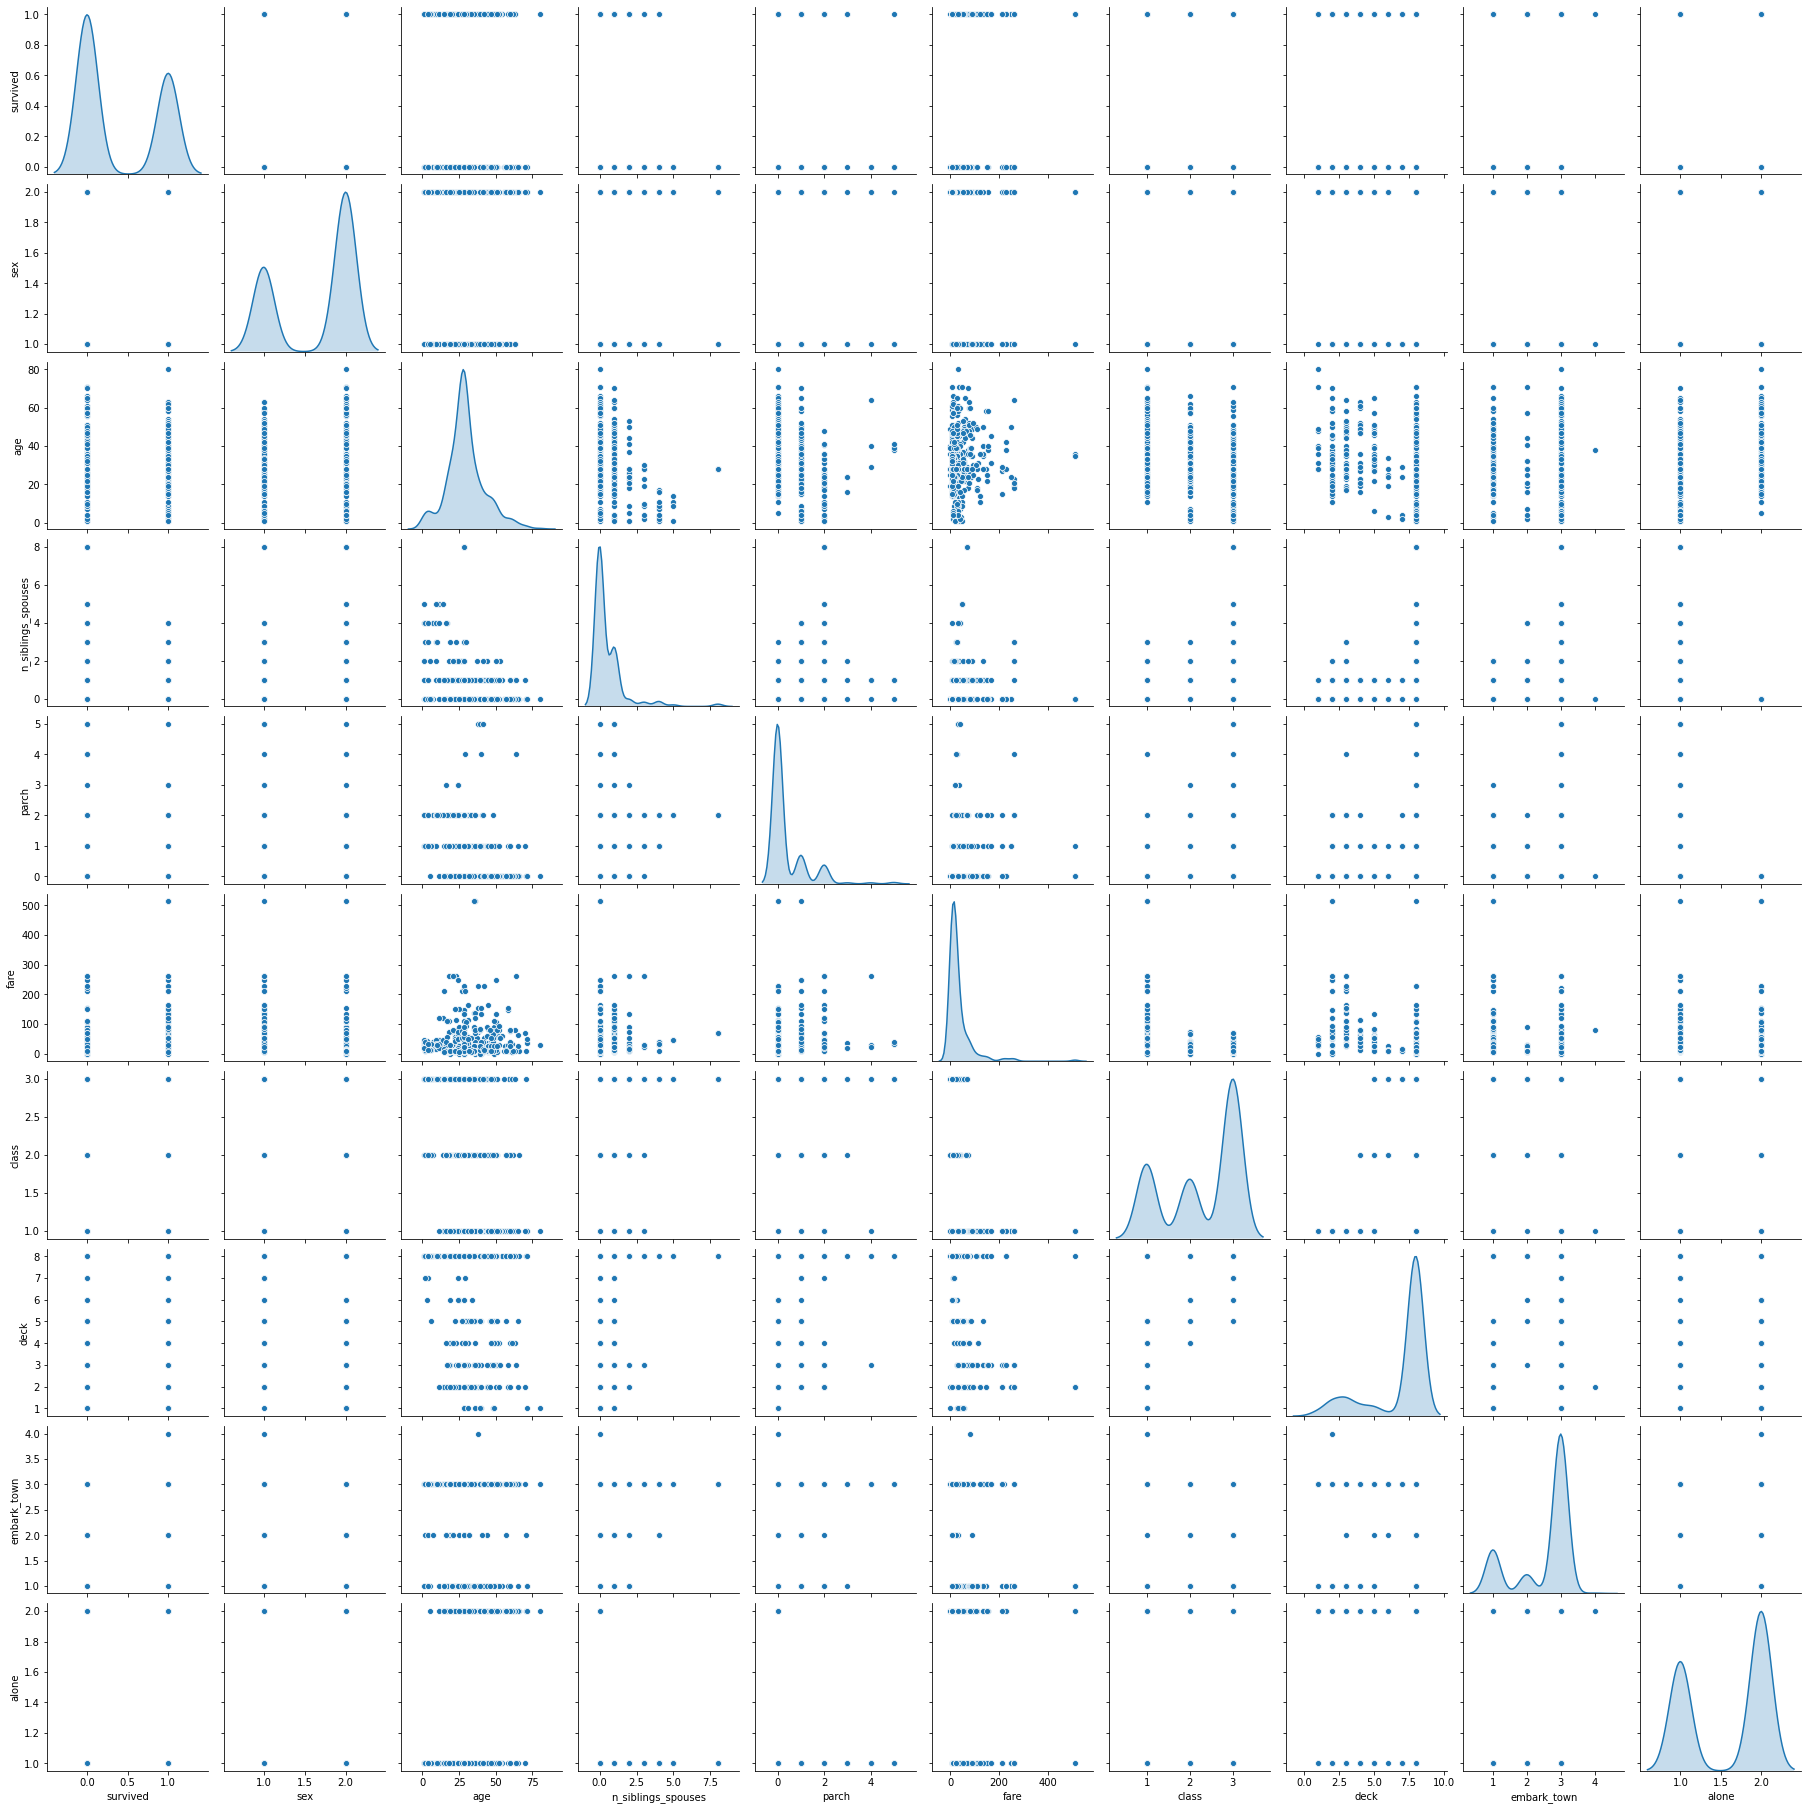

In [550]:
#Plot pairwise relationships in a dataset.

sns.pairplot(train_data, diag_kind='kde')
#sns.pairplot(train_data, diag_kind='kde')
#sns.pairplot(train_data[['survived','sex']], diag_kind='hist', height=2.5)
#sns.pairplot(train_data[['survived','sex']], diag_kind='kde', height=2.5)

### Split features from labels

Separate the target value, the "survived", from the features. This label, "survived" is the value that we will train the model to predict.

In [551]:
train_features = train_data.copy()
train_labels = train_features.pop('survived')

train_labels.tail()

622    0
623    0
624    1
625    0
626    0
Name: survived, dtype: int64

## Prepare Test Data

In [552]:
raw_td = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
raw_td.tail()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
259,1,female,25.0,0,1,26.0000,Second,unknown,Southampton,n
260,0,male,33.0,0,0,7.8958,Third,unknown,Southampton,y
261,0,female,39.0,0,5,29.1250,Third,unknown,Queenstown,n
262,0,male,27.0,0,0,13.0000,Second,unknown,Southampton,y
263,1,male,26.0,0,0,30.0000,First,C,Cherbourg,y


In [553]:
td = raw_td.copy() # make a deep copy

In [554]:
td.replace(cat2num, inplace=True)
td.tail()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
259,1,1,25.0,0,1,26.0000,2,8,3,1
260,0,2,33.0,0,0,7.8958,3,8,3,2
261,0,1,39.0,0,5,29.1250,3,8,2,1
262,0,2,27.0,0,0,13.0000,2,8,3,2
263,1,2,26.0,0,0,30.0000,1,3,1,2


In [555]:
# Prepare test data and test label
test_features = td.copy()
test_features.head()


,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,2,35.0,0,0,8.0500,3,8,3,2
1,0,2,54.0,0,0,51.8625,1,5,3,2
2,1,1,58.0,0,0,26.5500,1,3,3,2
3,1,1,55.0,0,0,16.0000,2,8,3,2
4,1,2,34.0,0,0,13.0000,2,4,3,2


In [556]:
test_labels = td.pop('survived')
test_features.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,2,35.0,0,0,8.0500,3,8,3,2
1,0,2,54.0,0,0,51.8625,1,5,3,2
2,1,1,58.0,0,0,26.5500,1,3,3,2
3,1,1,55.0,0,0,16.0000,2,8,3,2
4,1,2,34.0,0,0,13.0000,2,4,3,2


In [557]:
td.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,2,35.0,0,0,8.0500,3,8,3,2
1,2,54.0,0,0,51.8625,1,5,3,2
2,1,58.0,0,0,26.5500,1,3,3,2
3,1,55.0,0,0,16.0000,2,8,3,2
4,2,34.0,0,0,13.0000,2,4,3,2


In [558]:
test_labels.tail()

259    1
260    0
261    0
262    0
263    1
Name: survived, dtype: int64

## Creating the model (single-variable linear regression)

Now, we create a model that makes predictions based on single input. We could predict the survival based on age (And ignore all other data). This model will not be very accurate for obvious reasons!!

### Normalize Data
It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

The ```preprocessing.Normalization``` layer is a clean and simple way to build that preprocessing into your model.

In [559]:
age = np.array(train_features['age'])
age[-5:]

array([28., 25., 19., 28., 32.])

In [560]:
age_normalizer = preprocessing.Normalization(input_shape=[1,])
age_normalizer.adapt(age)

In [561]:
print(age_normalizer.mean.numpy())

[29.631]


### Build Sequential Model

In [562]:
age_model = tf.keras.Sequential([
    age_normalizer,
    layers.Dense(units=1)
])

age_model.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_19 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


### Compile Model

In [563]:
age_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


### Train Model

In [564]:
%%time
history = age_model.fit(
    train_features['age'], train_labels,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


Epoch 1/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6050 - val_loss: 0.3979
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4465 - val_loss: 0.4118
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4247 - val_loss: 0.3561
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4108 - val_loss: 0.3735
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4193 - val_loss: 0.3576
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4104 - val_loss: 0.3525
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4140 - val_loss: 0.3523
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4112 - val_loss: 0.3493
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4075 - val_loss: 0.3561
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4072 - val_loss: 0.3562
Epoch 11/

16/16 [==============================] - 0s 3ms/step - loss: 0.4214 - val_loss: 0.3441
Epoch 84/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4311 - val_loss: 0.3823
Epoch 85/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4095 - val_loss: 0.3587
Epoch 86/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4166 - val_loss: 0.3622
Epoch 87/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4206 - val_loss: 0.3641
Epoch 88/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4275 - val_loss: 0.3546
Epoch 89/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4184 - val_loss: 0.3689
Epoch 90/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4081 - val_loss: 0.3518
Epoch 91/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4047 - val_loss: 0.3571
Epoch 92/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4098 - val_loss: 0.3601
Epoch 93/100


In [565]:
# Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,0.409430,0.347836,95
96,0.423436,0.346258,96
97,0.410058,0.345692,97
98,0.404976,0.346188,98
99,0.408001,0.360675,99


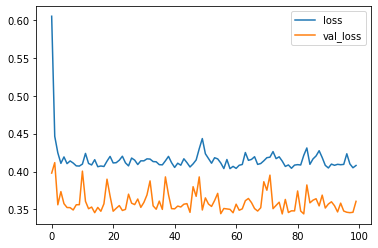

In [566]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()


### Evaluate the Model

In [567]:

test_results = age_model.evaluate(
    test_features['age'],
    test_labels, verbose=1)


9/9 [==============================] - 0s 1ms/step - loss: 0.3899


In [568]:
# See if our model predicts accurately with training data ?
age_model.predict(train_features['age'][:5])

array([[0.064],
       [0.059],
       [0.063],
       [0.06 ],
       [0.062]], dtype=float32)

### Predict using the Model
Since this is a single variable regression it's easy to look at the model's predictions as a function of the input


In [569]:
td1 = raw_td.copy() # deep copy test data
td1 = td1["age"]
td1.head()

0    35.0
1    54.0
2    58.0
3    55.0
4    34.0
Name: age, dtype: float64

In [570]:
predictions = age_model.predict(td1[:1])

In [571]:
print(predictions)

[[0.06]]


In [572]:
count_correct = 0
for p, actual in zip(predictions, test_labels):
    predicted = int(round(p[0])) # p is a numpy array with just one value.
    if (predicted == actual):
        count_correct += 1

print(f'Correctly predicted {count_correct} out of {len(test_labels)}')

Correctly predicted 1 out of 264


## Creating the model (single-variable linear regression)

Now, we create a model that makes predictions based on single input. We could predict the survival based on class (And ignore all other data). This model will not be very accurate for obvious reasons!!

### Normalize Data


In [573]:
deck = np.array(train_features['class'])
deck[-5:]

array([2, 3, 1, 3, 3])

In [574]:
#deck_normalizer = preprocessing.Normalization(input_shape=[1,])
deck_normalizer = preprocessing.Normalization()
deck_normalizer.adapt(deck)

In [575]:
print(deck_normalizer.mean.numpy())


[2.29]


### Build Sequential Model

In [576]:
deck_model = tf.keras.Sequential([
    deck_normalizer,
    layers.Dense(units=1)
])

deck_model.summary()


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_20 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


### Compile Model

In [577]:
deck_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


### Train Model

In [578]:
%%time
history = deck_model.fit(
    train_features['class'], train_labels,
    epochs=50,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


CPU times: user 2.17 s, sys: 122 ms, total: 2.29 s
Wall time: 1.77 s


In [579]:
# Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
45,0.347298,0.285491,45
46,0.349840,0.298440,46
47,0.352168,0.311128,47
48,0.355820,0.295443,48
49,0.364309,0.297848,49


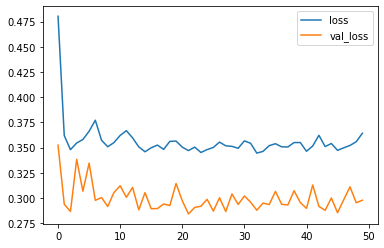

In [580]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()


### Evaluate the Model

In [581]:

test_results = deck_model.evaluate(
    test_features['class'],
    test_labels, verbose=1)


9/9 [==============================] - 0s 1ms/step - loss: 0.3371


In [582]:
# See if our model predicts accurately with training data ?
age_model.predict(train_features['class'][:5])

array([[0.069],
       [0.07 ],
       [0.069],
       [0.07 ],
       [0.069]], dtype=float32)

### Predict using the Model
Since this is a single variable regression it's easy to look at the model's predictions as a function of the input


In [583]:
td2 = train_data.copy() # deep copy test data
td2 = td2["class"]
td2.head()

0    3
1    1
2    3
3    1
4    3
Name: class, dtype: int64

In [584]:
predictions = age_model.predict(td2[:6])

In [585]:
print(predictions)

[[0.069]
 [0.07 ]
 [0.069]
 [0.07 ]
 [0.069]
 [0.069]]


In [586]:
count_correct = 0
for p, actual in zip(predictions, test_labels):
    predicted = int(round(p[0])) # p is a numpy array with just one value.
    if (predicted == actual):
        count_correct += 1

print(f'Correctly predicted {count_correct} out of {len(test_labels)}')

Correctly predicted 2 out of 264


## Creating the model (multi-variable linear regression)

Now, we create a model that makes predictions based on multiple inputs.

### Normalize Data
It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

The ```preprocessing.Normalization``` layer is a clean and simple way to build that preprocessing into your model.

In [587]:
# The first step is to create the layer
normalizer = preprocessing.Normalization()


In [588]:
train_features

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,2,22.0,1,0,7.2500,3,8,3,1
1,1,38.0,1,0,71.2833,1,3,1,1
2,1,26.0,0,0,7.9250,3,8,3,2
3,1,35.0,1,0,53.1000,1,3,3,1
4,2,28.0,0,0,8.4583,3,8,2,2
...,...,...,...,...,...,...,...,...,...
622,2,28.0,0,0,10.5000,2,8,3,2
623,2,25.0,0,0,7.0500,3,8,3,2
624,1,19.0,0,0,30.0000,1,2,3,2
625,1,28.0,1,2,23.4500,3,8,3,1


In [589]:
# Then adapt() it to the data
normalizer.adapt(np.array(train_features))


In [590]:
# This calculates the mean and variance, and stores them in the layer. 
print(normalizer.mean.numpy())


[ 1.654 29.631  0.545  0.38  34.385  2.29   6.904  2.525  1.593]


In [591]:
# When the layer is called it returns the input data, with each feature independently normalized
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[ 2.   22.    1.    0.    7.25  3.    8.    3.    1.  ]]

Normalized: [[ 0.73 -0.61  0.4  -0.48 -0.5   0.84  0.52  0.59 -1.21]]


### Create Model

In [592]:

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_21 (Normalizat (None, 9)                 19        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [593]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [594]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


CPU times: user 4.17 s, sys: 226 ms, total: 4.39 s
Wall time: 3.35 s


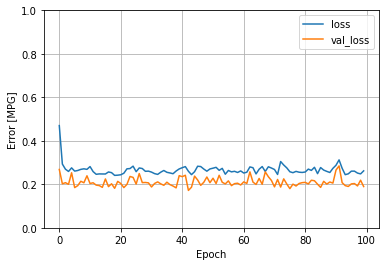

In [595]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)


## Run the model on test data

In [596]:
test_features.tail()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
259,1,1,25.0,0,1,26.0000,2,8,3,1
260,0,2,33.0,0,0,7.8958,3,8,3,2
261,0,1,39.0,0,5,29.1250,3,8,2,1
262,0,2,27.0,0,0,13.0000,2,8,3,2
263,1,2,26.0,0,0,30.0000,1,3,1,2


In [597]:
test_labels.tail()

259    1
260    0
261    0
262    0
263    1
Name: survived, dtype: int64

In [598]:
# Returns the loss value & metrics values for the model in test mode.
test_results = linear_model.evaluate(
    test_features.drop(columns=['survived']), test_labels, verbose=1)


9/9 [==============================] - 0s 1ms/step - loss: 0.2787


In [599]:
print(test_results)

0.2787308990955353


In [600]:
tf1 = test_features.drop(columns=['survived']) # Remove col that would be predicted.

predictions = linear_model.predict(tf1)
print("First 5 predictions: ", predictions[:5])
print("Last 5 predictions: ", predictions[-5:])

First 5 predictions:  [[0.041]
 [0.152]
 [1.016]
 [0.97 ]
 [0.081]]
Last 5 predictions:  [[0.899]
 [0.041]
 [0.595]
 [0.077]
 [0.099]]


In [601]:
count_correct = 0
for p, actual in zip(predictions, test_labels):
    predicted = int(round(p[0])) # p is a numpy array with just one value.
    if (predicted == actual):
        count_correct += 1

print(f'Correctly predicted {count_correct} out of {len(test_labels)}')

Correctly predicted 196 out of 264
